In [59]:
import numpy as np
import pandas as pd
from copy import deepcopy
import networkx as nx
from sklearn.neighbors import NearestNeighbors

from core.MicronsCAVE import CAVE

class Skeleton:

    @staticmethod
    def connect_disjoint_branches(G, soma_node=-1):
        G = deepcopy(G)
        G.remove_edges_from(list(nx.selfloop_edges(G)))

        components = list(nx.connected_components(G))
        root_component = [c for c in components if soma_node in c][0]
        components.remove(root_component)

        soma_pos = G.nodes[soma_node]['pos']

        for component in components:
            component = list(component)
            leaf_nodes = [node for node in component if G.degree(node) == 1]
            distances = [np.linalg.norm(G.nodes[leaf_node]['pos'] - soma_pos) for leaf_node in leaf_nodes]

            closest_leaf_node = leaf_nodes[np.argmin(distances)]
            G.add_edge(soma_node, closest_leaf_node)
    
        return G
    
    @staticmethod
    def direct_tree_from_root(mst, soma_node=-1):
        directed_tree = nx.DiGraph(cell_id=mst.graph['cell_id'], cell_type=mst.graph['cell_type'])

        # Copy node attributes
        for node, attrs in mst.nodes(data=True):
            directed_tree.add_node(node, **attrs)

        visited = {node: False for node in mst.nodes()}
        
        queue = [soma_node]
        visited[soma_node] = True
        
        while queue:
            node = queue.pop(0)
            
            for neighbor in mst.neighbors(node):
                if not visited[neighbor]:
                    # Copy the edge attributes
                    directed_tree.add_edge(node, neighbor, **mst[node][neighbor])
                    
                    visited[neighbor] = True
                    queue.append(neighbor)
                    
        return directed_tree
    
    @staticmethod
    def is_start_of_twig(node, tree):
        """Check if the node is the start of a twig."""
        parents = list(tree.predecessors(node))
        siblings = [child for parent in parents for child in tree.successors(parent) if child != node]
        
        # A node is the start of a twig if its parent has multiple children
        return bool(siblings)

    @staticmethod
    def walk_twig(node, tree):
        """Walk the twig starting from the node and return the nodes in the twig."""
        twig_nodes = [node]
        children = list(tree.successors(node))
        
        if len(children) > 1:
            return [node, node]

        while len(children) == 1:
            node = children[0]
            twig_nodes.append(node)
            children = list(tree.successors(node))
        
        return twig_nodes

    @staticmethod
    def closest_sibling(node, siblings, G):
        dists = [np.linalg.norm(G.nodes[node]['pos'] - G.nodes[sib]['pos']) for sib in siblings]
        return siblings[np.argmin(dists)]

    @staticmethod
    def merge_twig(twig_nodes, sibling, parent, G, log=False):
        sibling_twig_nodes = Skeleton.walk_twig(sibling, G)
        if len(sibling_twig_nodes)>1 and sibling_twig_nodes[0] == sibling_twig_nodes[1]:
            sibling_twig_nodes = [sibling]

        # calculate distances from parent to all nodes in twig and sibling twig
        all_nodes = np.array(twig_nodes + sibling_twig_nodes)
        all_dists = [np.linalg.norm(G.nodes[node]['pos'] - G.nodes[parent]['pos']) for node in twig_nodes]
        all_dists.extend([np.linalg.norm(G.nodes[node]['pos'] - G.nodes[parent]['pos']) for node in sibling_twig_nodes])

        # reorder nodes in twig and sibling twig based on distance to parent
        ordered_nodes = all_nodes[np.argsort(all_dists)]

        # print("Merging twig nodes {} and sibling twig nodes {} to {}".format(twig_nodes, sibling_twig_nodes, ordered_nodes))
        
        # remove edges in twig, sibling twig, and from both to parent
        if len(twig_nodes) > 1:
            for pnode, cnode in zip(twig_nodes[:-1], twig_nodes[1:]):
                G.remove_edge(pnode, cnode)
        if len(sibling_twig_nodes) > 1:
            for pnode, cnode in zip(sibling_twig_nodes[:-1], sibling_twig_nodes[1:]):
                G.remove_edge(pnode, cnode)
        G.remove_edge(parent, twig_nodes[0])
        G.remove_edge(parent, sibling_twig_nodes[0])

        # add edges based on ordered nodes
        G.add_edge(parent, ordered_nodes[0], weight=np.linalg.norm(G.nodes[ordered_nodes[0]]['pos'] - G.nodes[parent]['pos']))
        for pnode, cnode in zip(ordered_nodes[:-1], ordered_nodes[1:]):
            G.add_edge(pnode, cnode, weight=np.linalg.norm(G.nodes[cnode]['pos'] - G.nodes[pnode]['pos']))
        
        return
    
    @staticmethod
    def remove_short_twigs(tree, k):
        while True:
            twig_to_remove = None

            # 1. Identify a short twig
            for node in tree.nodes():
                if len(list(tree.successors(node))) == 0:
                    siblings = [child for parent in tree.predecessors(node) for child in tree.successors(parent) if child != node]
                    if len(siblings) > 0:
                        twig_to_remove = ([node], Skeleton.closest_sibling(node, siblings, tree))
                elif Skeleton.is_start_of_twig(node, tree):
                    twig_nodes = Skeleton.walk_twig(node, tree)
                    if len(twig_nodes) > k:
                        continue
                    elif len(twig_nodes) == 2 and twig_nodes[0] == twig_nodes[1]:
                        continue
                    else:
                        start_node = twig_nodes[0]
                        siblings = [child for parent in tree.predecessors(start_node) 
                                    for child in tree.successors(parent) if child != start_node]
                        
                        # Check if there are sibling twigs
                        if any(Skeleton.is_start_of_twig(sibling, tree) for sibling in siblings):
                            twig_to_remove = (twig_nodes, Skeleton.closest_sibling(start_node, siblings, tree))
                            break
            
            # If no twigs to remove, exit loop
            if not twig_to_remove:
                break

            # 2. Merge the twig
            parent = list(tree.predecessors(twig_to_remove[0][0]))[0]
            Skeleton.merge_twig(*twig_to_remove, parent, tree, log=True)
                        
        return tree
    
    @staticmethod
    def prune_unknown_twigs(tree, pre=True):

        leaves = [node for node, degree in tree.out_degree() if degree == 0]

        try:
            if tree.nodes[leaves[0]]['cell_type']:
                key = 'cell_type'
        except KeyError:
            key = 'cell_type_pre' if pre else 'cell_type_post'

        # get the path-length from each leaf to its first parent/grandparent/grandgrandparent/... node with a sibling
        # if no node with a sibling is found, the path length is the length of the path to the root
        inh_paths = []
        for leaf in leaves:
            l = 1
            path = [deepcopy(leaf)]
            siblings = [child for parent in tree.predecessors(leaf) for child in tree.successors(parent) if child != leaf]
            while len(siblings) == 0 and l < len(tree.nodes()):
                l += 1
                leaf = list(tree.predecessors(leaf))[0]
                path.append(deepcopy(leaf))
                siblings = [child for parent in tree.predecessors(leaf) for child in tree.successors(parent) if child != leaf]

            if np.all([tree.nodes[node][key]=='Unknown' for node in path]):
                inh_paths.append(path)

        # remove all pure unknown twigs
        for path in inh_paths:
            for node in path:
                tree.remove_node(node)

        return tree

    def __init__(self, cell_info, syn_group, syn_k=6, soma_k=12):
        
        self.cell_id = cell_info['pt_root_id'].values[0]
        self.cell_type = cell_info['cell_type'].values[0]
        self.n_synapses = syn_group.shape[0]

        group_size = syn_group.shape[0]
        if group_size < syn_k:
            syn_k = group_size
        if group_size < soma_k:
            soma_k = group_size
        
        self.syn_k = syn_k
        self.soma_k = soma_k

        self.mst = self.skeletonize(cell_info, syn_group, syn_k, soma_k)
        self.smooth_mst = None

    def skeletonize(self, cell_info, syn_group, syn_k, soma_k):

        # Keep relevant rows of synapse table
        synapses = syn_group[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']]

        # Get the soma location for the cell
        # cell_info = cells_df.loc[cell_id]
        cell_id = cell_info['pt_root_id'].values[0]
        cell_type = cell_info['cell_type'].values[0]
        soma_xyz = np.array(cell_info[['pt_x', 'pt_y', 'pt_z']].values)
        # soma_xyz = np.matmul(soma_xyz, np.diag([4/1000, 4/1000, 40/1000]))

        # Add the soma location to the synapse table
        soma_df = pd.DataFrame(soma_xyz)
        soma_df.columns = ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']
        soma_df.index = [-1]
        synapses_w_soma = pd.concat([synapses, soma_df])

        # Create a kdtree from the synapse locations
        kd_tree = NearestNeighbors(n_neighbors=syn_k, algorithm='kd_tree').fit(synapses_w_soma.values)

        # Get the k nearest neighbors for each synapse and the soma
        distances, indices = kd_tree.kneighbors(synapses.values)
        soma_distances, soma_indices = kd_tree.kneighbors(soma_xyz.reshape(1, -1), n_neighbors=soma_k)

        # Subtract the "radius" of the soma from the soma distances
        soma_radius = soma_distances[0][1]
        soma_distances = soma_distances - soma_radius 

        # Create a graph from the synapse group
        nodes = list(synapses.index.values)
        G = nx.Graph(cell_id=cell_id, cell_type=cell_type)
        for node in nodes:
            node_ct_pre = syn_group.loc[node, 'cell_type_pre']
            node_ct_post = syn_group.loc[node, 'cell_type_post']
            node_id = syn_group.loc[node, 'id']
            node_pre_id = syn_group.loc[node, 'pre_pt_root_id']
            node_post_id = syn_group.loc[node, 'post_pt_root_id']
            G.add_node(node, pos=synapses.loc[node, ['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].values,
                             cell_type_pre=node_ct_pre,
                             cell_type_post=node_ct_post,
                             syn_id=node_id,
                             pre_cell_id=node_pre_id,
                             post_cell_id=node_post_id)
        nodes.append(-1)
        G.add_node(-1, pos=soma_xyz, cell_type_pre=-1, cell_type_post=-1, syn_id=-1, pre_cell_id=-1, post_cell_id=-1)

        # Add edges according to the kdtree
        for i in range(len(indices)):
            syn_id = nodes[i]
            for j in range(len(indices[i])):
                if i != indices[i][j]:
                    G.add_edge(syn_id, nodes[indices[i][j]], weight=distances[i][j])
        
        # Add edges from the soma to its nearest neighbors, corrected for the radius of the soma
        # Make sure not to add an edge from the soma to itself
        for l in range(1,len(soma_indices[0])):
            G.add_edge(-1, nodes[soma_indices[0][l]], weight=soma_distances[0][l])

        # Get the minimum spanning tree
        mst = nx.minimum_spanning_tree(G)

        # Make the graph fully connected
        mst = Skeleton.connect_disjoint_branches(mst)

        # Direct the tree from the soma
        mst = Skeleton.direct_tree_from_root(mst, soma_node=-1)

        return mst

    def smooth(self, twig_length, prune_unknown=True):
        DG = deepcopy(self.mst)
        if prune_unknown:
            DG = Skeleton.prune_unknown_twigs(DG)
        
        DG = Skeleton.remove_short_twigs(DG, twig_length)
        self.smooth_mst = DG
        self.twig_length = twig_length

        return self.smooth_mst
    
    def extract_excitatory_smooth_mst(self, pre=True):
        DG = deepcopy(self.smooth_mst)

        try:
            if DG.nodes[0]['cell_type']:
                key = 'cell_type'
        except KeyError:
            key = 'cell_type_pre' if pre else 'cell_type_post'
        
        nodes_to_remove = []
        for node in DG.nodes:
            if node > 0 and DG.nodes[node][key] == 'Unknown' and len(list(DG.successors(node))) < 2:
                nodes_to_remove.append(node)
        for node in nodes_to_remove:
            children = list(DG.successors(node))
            parent = list(DG.predecessors(node))[0]
            DG.remove_node(node)
            for child in children:
                DG.add_edge(parent, child)
        return DG
    
    def get_paths(self, smoothed=True, duplicate_tail=False):

        if smoothed:
            graph = self.smooth_mst
        else:
            graph = self.mst

        # first get all leaves
        leaves = [node for node, degree in graph.out_degree() if degree == 0]

        # for each leaf, walk to its parent until you reach a node with no parents
        # save a list of (node, number of children) tuples
        paths = set()
        for leaf in leaves:
            path = [(leaf, 0)]
            current_node = leaf
            while len(list(graph.predecessors(current_node))) > 0:
                parent = list(graph.predecessors(current_node))[0]
                num_siblings = len(list(graph.successors(parent)))
                path.append((parent, num_siblings))
                current_node = parent

            # reverse the path so that it goes from soma to leaf, then skip soma node
            path.reverse()
            path = path[1:]

            # split the path at nodes with more than one child, duplicating the node in both lists
            split_paths = []
            current_path = []
            for node, num_children in path:
                current_path.append(node)
                if num_children > 1 or num_children == 0:
                    split_paths.append(tuple(current_path))
                    if duplicate_tail:
                        current_path = [node]
                    else:
                        current_path = []

            paths.update(split_paths)
        
        return paths

In [3]:
exc_cells = pd.read_csv('data/exc_cells.csv')

In [4]:
exc_cells.head()

,pt_root_id,cell_type,pt_x,pt_y,pt_z
0,864691135639004475,23P,284.544,442.112,808.80
1,864691135771677771,23P,290.304,434.624,811.64
2,864691135864089470,23P,318.528,485.824,670.16
3,864691135560505569,23P,320.512,496.000,662.52
4,864691136315868311,23P,320.576,507.712,664.88


In [8]:
client = CAVE()
syn_table = client.download_input_synapses(int(exc_cells.loc[200].pt_root_id), cell_df=exc_cells)
syn_table.head()

Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


,id,pre_pt_root_id,post_pt_root_id,size,cell_type_pre,cell_type_post,ctr_pt_x,ctr_pt_y,ctr_pt_z
0,6394126,864691134189750724,864691135429211833,4364,Unknown,23P,323.380,549.664,716.12
1,6919810,864691135278368888,864691135429211833,736,Unknown,23P,322.224,545.408,715.04
2,25586150,864691132769905129,864691135429211833,8132,Unknown,23P,402.496,509.816,694.64
3,17121017,864691134182816733,864691135429211833,13996,Unknown,23P,371.424,525.080,696.04
4,17120267,864691134182826205,864691135429211833,15312,Unknown,23P,369.128,526.600,699.20


In [17]:
syn_table = client.download_input_synapses(int(exc_cells.loc[2000].pt_root_id), cell_df=exc_cells)

print(len(syn_table[syn_table['cell_type_pre'] != 'Unknown']))

Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


156


In [60]:
skl = Skeleton(exc_cells[exc_cells['pt_root_id']==exc_cells.loc[2000].pt_root_id], syn_table, syn_k=6, soma_k=12)

(array([723., 286., 130.,  83.,  58.,  37.,   0.,  22.,  29.,   8.,   3.,
          4.,   2.,   0.,   0.,   0.,   2.,   1.,   1.,   1.]),
 array([ 1.  ,  1.85,  2.7 ,  3.55,  4.4 ,  5.25,  6.1 ,  6.95,  7.8 ,
         8.65,  9.5 , 10.35, 11.2 , 12.05, 12.9 , 13.75, 14.6 , 15.45,
        16.3 , 17.15, 18.  ]),
 <BarContainer object of 20 artists>)

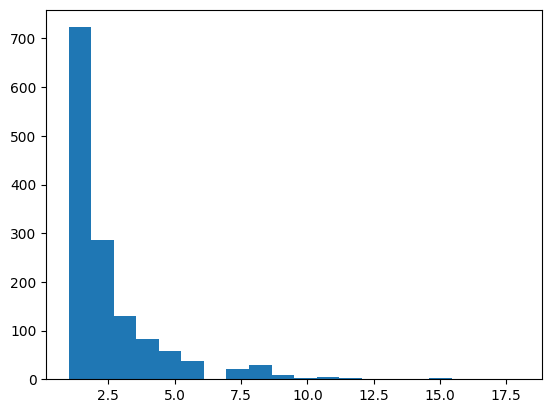

In [61]:
all_paths = skl.get_paths(smoothed=False, duplicate_tail=False)
import matplotlib.pyplot as plt

plt.hist([len(path) for path in all_paths], bins=20)

In [62]:
smooth_mst = skl.smooth(3, prune_unknown=False)

(array([36., 36., 16.,  7.,  9.,  4.,  8.,  3.,  6.,  2.,  6.,  1.,  2.,
         3.,  3.,  1.,  3.,  1.,  1.,  1.]),
 array([ 1.  ,  5.65, 10.3 , 14.95, 19.6 , 24.25, 28.9 , 33.55, 38.2 ,
        42.85, 47.5 , 52.15, 56.8 , 61.45, 66.1 , 70.75, 75.4 , 80.05,
        84.7 , 89.35, 94.  ]),
 <BarContainer object of 20 artists>)

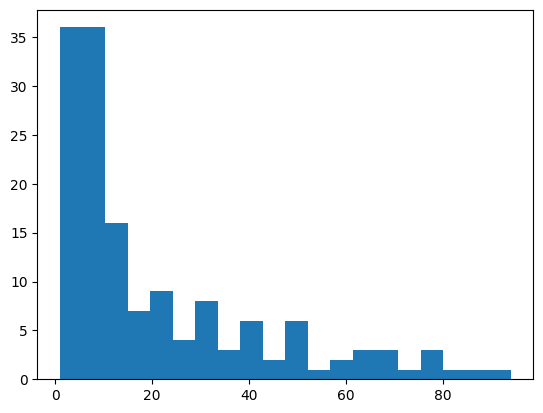

In [63]:
smooth_paths = skl.get_paths(smoothed=True, duplicate_tail=False)

plt.hist([len(path) for path in smooth_paths], bins=20)

In [58]:
leaves = [node for node, degree in skl.mst.out_degree() if degree == 0]
key = None
print(leaves)
try:
    if skl.mst.nodes[leaves[0]]['cell_type']:
        key = 'cell_type'
except KeyError:
    key = 'cell_type_pre'

print(key)

[3, 18, 20, 27, 34, 35, 44, 47, 50, 53, 56, 57, 69, 74, 76, 77, 80, 85, 92, 94, 99, 100, 105, 109, 110, 120, 121, 124, 127, 129, 141, 148, 152, 157, 158, 172, 174, 182, 183, 185, 193, 195, 196, 199, 200, 201, 204, 208, 210, 213, 218, 221, 228, 234, 238, 241, 243, 245, 254, 256, 261, 268, 271, 274, 276, 277, 280, 281, 282, 284, 288, 289, 293, 308, 310, 317, 321, 324, 326, 331, 334, 338, 345, 353, 358, 359, 360, 361, 365, 368, 371, 374, 375, 381, 388, 390, 394, 398, 408, 411, 414, 416, 418, 421, 424, 432, 435, 448, 449, 458, 461, 462, 463, 474, 475, 477, 482, 486, 490, 492, 493, 494, 496, 499, 503, 507, 517, 521, 533, 538, 543, 546, 548, 559, 568, 572, 577, 582, 583, 585, 586, 596, 599, 600, 602, 609, 612, 615, 617, 627, 628, 629, 631, 633, 642, 644, 645, 648, 649, 651, 662, 664, 666, 667, 670, 671, 686, 687, 692, 697, 706, 707, 714, 719, 725, 731, 732, 736, 741, 745, 746, 751, 752, 753, 763, 766, 780, 788, 789, 799, 803, 813, 815, 816, 824, 828, 835, 837, 844, 849, 851, 853, 859, 865, 8

In [56]:
skl.mst.nodes[3]

{'pos': array([502.2  , 621.376, 751.44 ]),
 'cell_type_pre': 'Unknown',
 'cell_type_post': '23P',
 'syn_id': 64497585,
 'pre_cell_id': 864691136589616612,
 'post_cell_id': 864691136296739611}

In [64]:
smooth_pruned_mst = skl.smooth(3, prune_unknown=True)

(array([12., 26., 12.,  2.,  8.,  4.,  2.,  5.,  2.,  2.,  2.,  4.,  2.,
         3.,  4.,  2.,  0.,  2.,  3.,  1.]),
 array([ 1. ,  4.7,  8.4, 12.1, 15.8, 19.5, 23.2, 26.9, 30.6, 34.3, 38. ,
        41.7, 45.4, 49.1, 52.8, 56.5, 60.2, 63.9, 67.6, 71.3, 75. ]),
 <BarContainer object of 20 artists>)

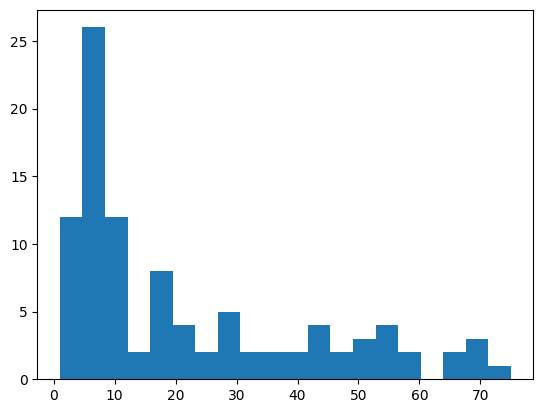

In [65]:
smooth_paths = skl.get_paths(smoothed=True, duplicate_tail=False)

plt.hist([len(path) for path in smooth_paths], bins=20)

In [66]:
smooth_pruned_emst = skl.extract_excitatory_smooth_mst(pre=True)

In [68]:
smooth_pruned_emst.nodes

NodeView((0, 1, 27, 28, 54, 73, 74, 75, 93, 101, 175, 197, 212, 219, 238, 240, 260, 263, 270, 278, 295, 317, 320, 352, 354, 362, 369, 379, 391, 411, 412, 446, 447, 455, 483, 494, 510, 533, 534, 535, 547, 600, 601, 650, 655, 694, 707, 713, 723, 724, 769, 785, 796, 807, 826, 876, 890, 893, 896, 916, 936, 938, 948, 964, 972, 978, 986, 988, 996, 997, 1058, 1062, 1077, 1092, 1103, 1114, 1115, 1130, 1135, 1136, 1147, 1179, 1199, 1201, 1205, 1222, 1235, 1293, 1296, 1301, 1329, 1342, 1361, 1375, 1391, 1405, 1411, 1436, 1441, 1446, 1455, 1487, 1491, 1494, 1500, 1502, 1535, 1538, 1546, 1568, 1594, 1603, 1627, 1628, 1649, 1688, 1698, 1714, 1722, 1729, 1735, 1736, 1744, 1770, 1790, 1799, 1804, 1811, 1826, 1853, 1861, 1892, 1898, 1912, 1928, 1935, 1968, 1972, 1985, 2008, 2013, 2027, 2049, 2125, 2132, 2149, 2150, 2168, 2184, 2189, 2199, 2206, 2254, 2297, 2336, 2359, 2370, 2371, 2384, 2409, 2427, 2435, 2438, 2453, 2457, 2470, 2482, 2503, 2506, 2524, 2527, 2532, 2538, 2561, 2569, 2573, 2608, 2612, 266